# Exercises Chapters 13 & 14

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [8]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

## Air Pollution
In the previous chapter, as an exercise, we prepared the air pollution dataset for deep
learning modeling. Now we’ll use the training set, validation set, and test set to build
baseline models and evaluate them.

For each type of model, follow the steps outlined. Recall that the target for the singlestep and multi-step model is the concentration of NO2, and the targets for the multioutput model are the concentration of NO2 and temperature. 

1. For the single-step model

    a. Build a baseline model that predicts the last known value.
   
    b. Plot it.
   
    c .Evaluate its performance using the mean absolute error (MAE) and store it for comparison in a dictionary.
   
3. For the multi-step model
   
    a. Build a baseline that predicts the last known value over a horizon of 24 hours.
   
    b. Build a baseline model that repeats the last 24 hours.
   
    c. Plot the predictions of both models.
   
    d. Evaluate both models using the MAE and store their performance.
   
5. For the multi-output model
   
    a. Build a baseline model that predicts the last known value.
   
    b. Plot it.
   
    c. Evaluate its performance using the MAE and store it for comparison in a dictionary.

In [14]:
train_df = pd.read_csv('data/ex_train.csv')
val_df = pd.read_csv('data/ex_val.csv')
test_df = pd.read_csv('data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [16]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [18]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

### 1. For the single-step model

#### 1.a Build a baseline model that predicts the last known value

In [25]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2']) 

wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [27]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [29]:
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [31]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

119/119 [==============================] - 1s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0287


#### 1.b Plot it

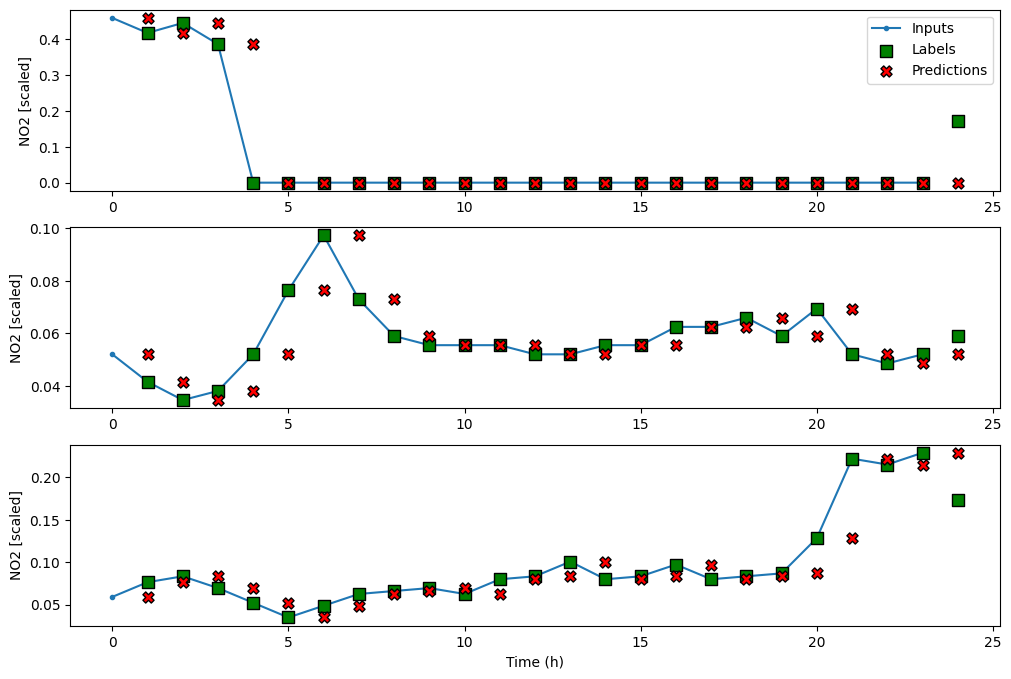

In [34]:
wide_window.plot(baseline_last)

#### 1.c Evaluate its performance using the mean absolute error (MAE) and store it for comparison in a dictionary.

In [39]:
# MAE of Baseline on the test set
mae_baseline = performance['Baseline - Last'][1]
print(f'MAE of baseline on the test set: {mae_baseline:.4}')

MAE of baseline on the test set: 0.03336


### 2. For the multi-step model

#### 2.a Build a baseline that predicts the last known value over a horizon of 24 hours.

In [43]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [45]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [47]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 1s 4ms/step - loss: 0.1443 - mean_absolute_error: 0.2821


#### 2.c Plot the predictions of both models.

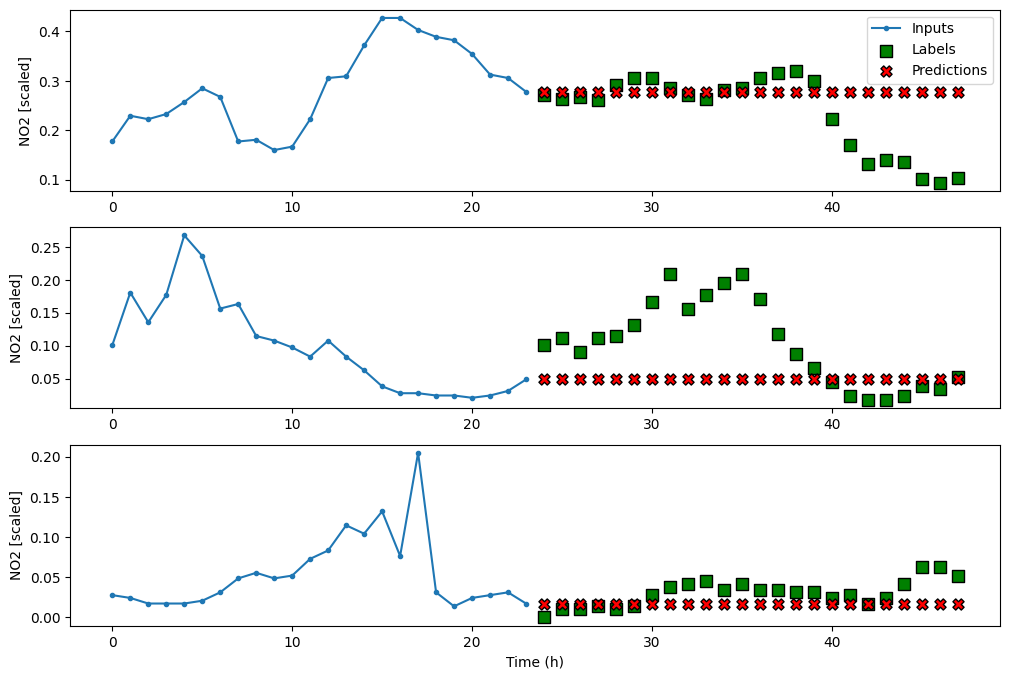

In [49]:
multi_window.plot(ms_baseline_last)

In [52]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [54]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 [==============================] - 1s 3ms/step - loss: 0.1426 - mean_absolute_error: 0.2818


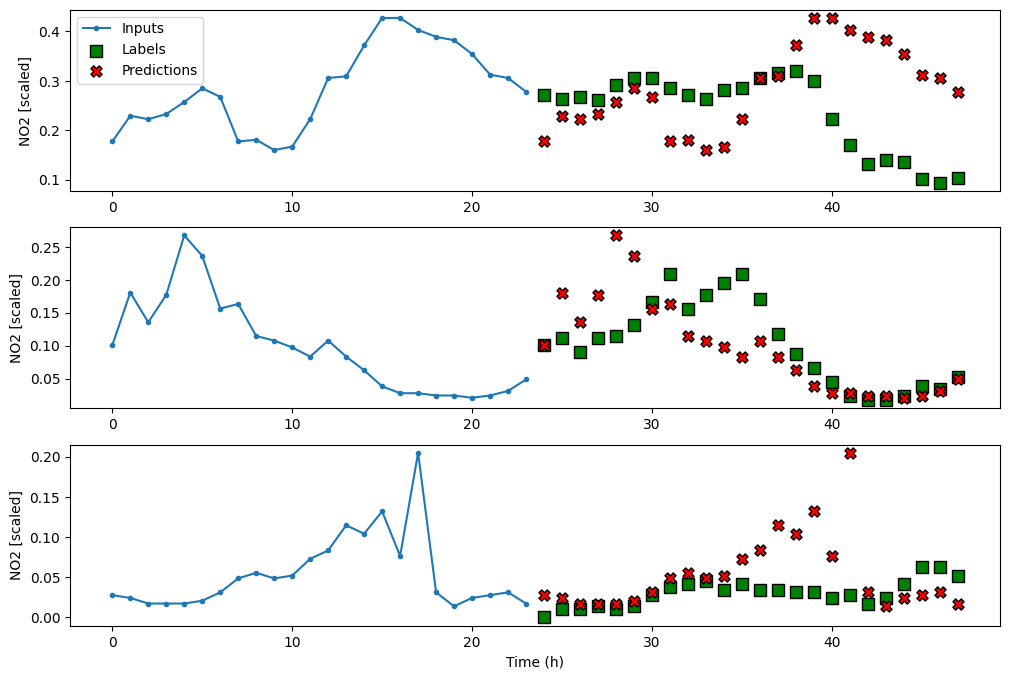

In [56]:
multi_window.plot(ms_baseline_repeat)

### 3. For the multi-output model

In [59]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])